<a href="https://colab.research.google.com/github/daniabib/object-detection-plg/blob/main/R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download dataset and libraries

https://www.kaggle.com/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset

In [1]:
!pip install -q --upgrade selectivesearch torch_snippets
from google.colab import files
files.upload()

     |████████████████████████████████| 48 kB 3.4 MB/s 
     |████████████████████████████████| 60 kB 5.0 MB/s 
     |████████████████████████████████| 10.9 MB 13.7 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 232 kB 31.2 MB/s 
     |████████████████████████████████| 948 kB 58.2 MB/s 
     |████████████████████████████████| 58 kB 3.2 MB/s 
     |████████████████████████████████| 51 kB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danabib","key":"0bfeaa9e2c343fcc7984a40df00682b2"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

kaggle.json
100% 367M/367M [00:06<00:00, 82.5MB/s]
100% 367M/367M [00:06<00:00, 63.3MB/s]


In [32]:
from torch_snippets import *
from selectivesearch import selective_search 

from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
from torch.utils.data import DataLoader, Dataset

import pandas as pd

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Preparing the dataset

In [5]:
IMAGE_ROOT = "images/images"
df_raw = pd.read_csv("df.csv")
df_raw.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [7]:
len(df_raw["ImageID"].unique())

15225

XMin, XMax, YMin, and YMax correspond to the ground truth of
the bounding box of the image.

Define a class that returns the image and its corresponding class and ground truth along with the file path of the image.

In [15]:
class OpenImages(Dataset):
  def __init__(self, dataframe, image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df = dataframe
    self.unique_images = self.df["ImageID"].unique()
  
  def __len__(self): return len(self.unique_images)

  def __getitem__(self, index):
    image_id = self.unique_images[index]
    image_path = f"{self.root}/{image_id}.jpg"
    # Convert BGR to RGB
    image = cv2.imread(image_path, 1)[...,::-1]
    height, width, _ = image.shape
    df = self.df.copy()
    df = df[df["ImageID"] == image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes * np.array([width, height, width, height])).astype(np.uint16)\
                                                              .tolist()
    classes = df["LabelName"].values.tolist()
    return image, boxes, classes, image_path                                                              

In [16]:
dataset = OpenImages(df_raw)

In [17]:
len(dataset)

15225

In [22]:
image, bboxes, classes, _ = dataset[9]

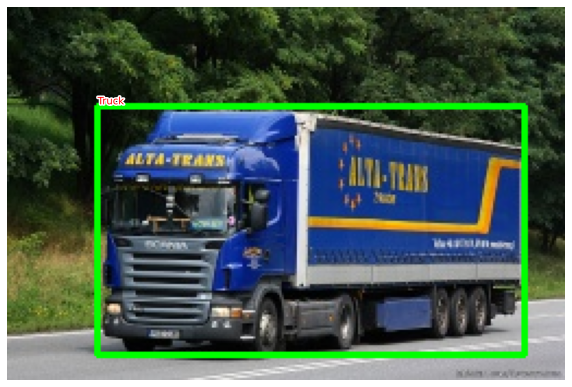

In [23]:
show(image, bbs=bboxes, texts=classes, sz=10)

In [33]:
def extract_candidates(image):
  image_label, regions = selective_search(image, scale=200, min_size=100)
  image_area = np.prod(image.shape)
  candidates = []
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*image_area): continue
    if r['size'] > (1*image_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))
  return candidates

In [26]:
def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2 - x1)
  height = (y2 - y1)
  if (width<0) or (height <0):
    return 0.0
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined+epsilon)
  return iou

## Fetching region proposals

In [29]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

In [28]:
N = 500

In [34]:
for index, (image, bboxes, labels, path) in enumerate(dataset):
  if index == N: break
  H, W, _ = image.shape
  candidates = extract_candidates(image)
  candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
  ious, rois, classes, deltas = [], [], [], []
  ious = np.array([[extract_iou(candidate, bbox) for candidate in candidates] 
                   for bbox in bboxes]).T
  for j, candidate in enumerate(candidates):
    x_min, y_min, x_max, y_max = candidate
    candidate_ious = ious[j]
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_bb = _x,_y,_X,_Y = bboxes[best_iou_at]
    if best_iou > 0.3: 
      classes.append(labels[best_iou_at])
    else: 
      classes.append('background')
    delta = np.array([_x-x_min, _y-y_min, _X-x_max, _Y-y_max]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))
  FPATHS.append(path)
  IOUS.append(ious)
  ROIS.append(rois)
  CLSS.append(classes)
  DELTAS.append(deltas)
  GTBBS.append(bboxes)

In [45]:
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [54]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

## Creating the dataset

In [56]:
def preprocess_image(image):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  image = torch.tensor(image).permute(2, 0, 1)
  image = normalize(image)
  return image.to(device).float()

In [57]:
def decode(y):
  _, preds = y.max(-1)
  return preds

In [63]:
class RCNNDataset(Dataset):
  def __init__(self, paths, rois, labels, deltas, gtbbs):
    self.paths = paths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  
  def __len__(self): return len(self.paths)

  def __getitem__(self, index):
    path = str(self.paths[index])
    image = cv2.imread(path, 1)[...,::-1]
    H, W, _ = image.shape
    shape = np.array([W, H, W, H])
    gtbbs = self.gtbbs[index]
    rois = self.rois[index]
    bbs = (np.array(rois) * shape).astype(np.uint16)
    labels = self.labels[index]
    deltas = self.deltas[index]
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, gtbbs, path
  
  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for i in range(len(batch)):
        image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[i]
        crops = [cv2.resize(crop, (224,224)) for crop in crops]
        crops = [preprocess_image(crop/255.)[None] for crop in crops]
        input.extend(crops)
        labels.extend([label2target[c] for c in image_labels])
        deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas

In [59]:
n_train = 9*len(FPATHS)//10

In [64]:
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

In [65]:
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

## R-CNN network architecture

1. Define a VGG backbone.
2. Fetch the features post passing the normalized crop through a pretrained
model.
3. Attach a linear layer with sigmoid activation to the VGG backbone to
predict the class corresponding to the region proposal.
4. Attach an additional linear layer to predict the four bounding box offsets.
5. Define the loss calculations for each of the two outputs (one to predict class
and the other to predict the four bounding box offsets).
6. Train the model that predicts both the class of region proposal and the four
bounding box offsets.

In [67]:
vgg_base = models.vgg16(pretrained=True)
vgg_base

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
vgg_base.classifier = nn.Sequential()
for param in vgg_base.parameters():
  param.requeires_grad = False
vgg_base.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [69]:
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()

    feature_dim = 25088
    self.base = vgg_base
    self.class_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
        nn.Tanh(),
    )
    self.class_loss = nn.CrossEntropyLoss()
    self.bbox_loss = nn.L1Loss()

  def forward(self, input):
    features = self.base(input)
    class_score = self.class_score(features)
    bbox = self.bbox(features)
    return class_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.class_loss(probs, labels)
    indexes = torch.where(labels != 0)  
    _deltas = _deltas[indexes]
    deltas = deltas[indexes]
    self.lmb = 10.0
    if len(indexes) > 0:
        regression_loss = self.bbox_loss(_deltas, deltas)
        return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
        regression_loss = 0
        return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
  ...